## Cluster Analysis

It is basically a type of unsupervised learning method . An unsupervised learning method is a method in which we draw references from datasets consisting of input data without labeled responses. Generally, it is used as a process to find meaningful structure, explanatory underlying processes, generative features, and groupings inherent in a set of examples.
Clustering is the task of dividing the population or data points into a number of groups such that data points in the same groups are more similar to other data points in the same group and dissimilar to the data points in other groups. It is basically a collection of objects on the basis of similarity and dissimilarity between them.

### Why Clustering ?

Clustering is very much important as it determines the intrinsic grouping among the unlabeled data present. There are no criteria for a good clustering. It depends on the user, what is the criteria they may use which satisfy their need. For instance, we could be interested in finding representatives for homogeneous groups (data reduction), in finding “natural clusters” and describe their unknown properties (“natural” data types), in finding useful and suitable groupings (“useful” data classes) or in finding unusual data objects (outlier detection). This algorithm must make some assumptions which constitute the similarity of points and each assumption make different and equally valid clusters.

### Objective: 

The aim of this project is to do customer segmentation in a bank using the cluster analysis,inorder to develop a marketing strategy

### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv(r'C:\Users\R swetha\Desktop\PYTHON\CLUSTERING\german_credit_data.csv')

In [3]:
import warnings
warnings.filterwarnings("ignore")
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


### Exploratory Data Analysis

In [4]:
data.drop(data.columns[0], inplace=True, axis=1)  #Removing index column
print("Database has {} observations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print("\nMissing values in each column:\n{}".format(data.isnull().sum()))
print("\nColumns data types:\n{}".format(data.dtypes))

Database has 1000 observations (customers) and 9 columns (attributes).

Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Columns data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


Out of 8 columns 2 contain missing values. Probably these are customers who don’t have one of these two accounts

In [5]:
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [6]:
print("Unique values in each categorical column:\n")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:

Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


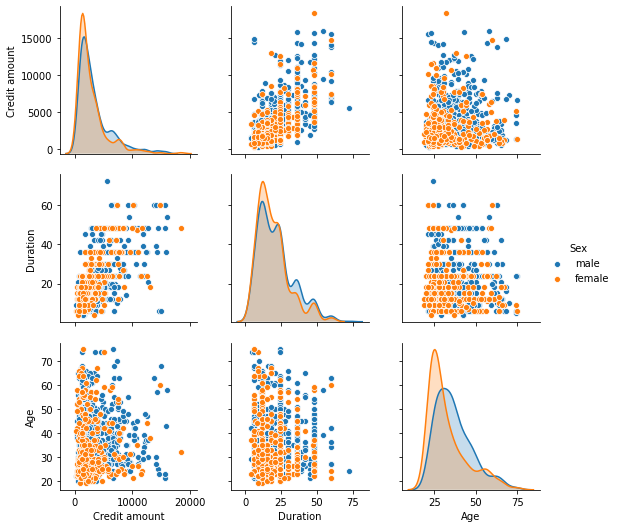

In [7]:
sns.pairplot(data,hue='Sex',vars=['Credit amount','Duration','Age'])
plt.show()

There is no clear difference between men and women in terms of amount and duration of the credit. From visual inspection, it seems that there is some positive correlation between duration and amount of credit, what makes sense.That makes sense because usually, people take bigger credits for longer periods.

By the 'age' variable,we can see that more women than men are younger.

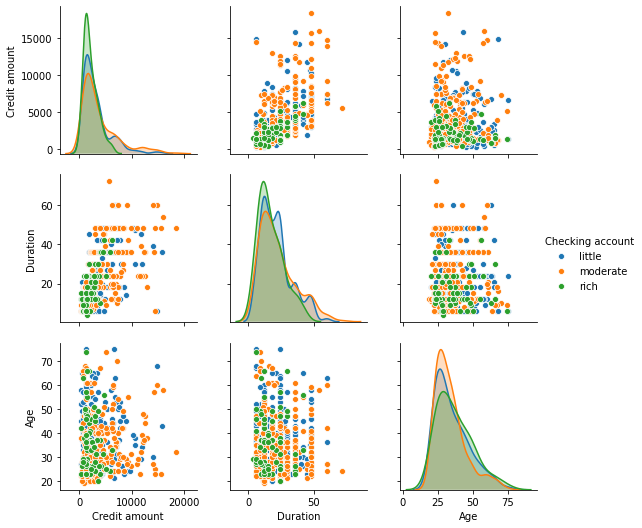

In [8]:
sns.pairplot(data,hue='Checking account',vars=['Credit amount','Duration','Age'])

There is no clear difference between categories of Checking account in terms of amount and duration of the credit. 

In [9]:
def boxes(x,y,h=None,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

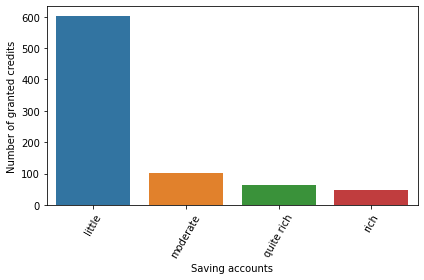

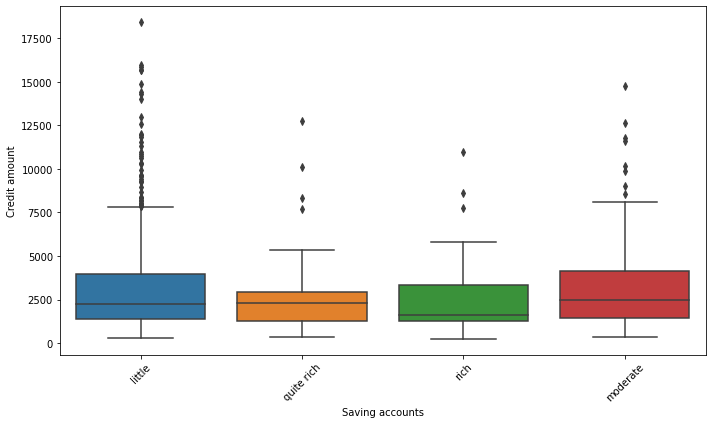

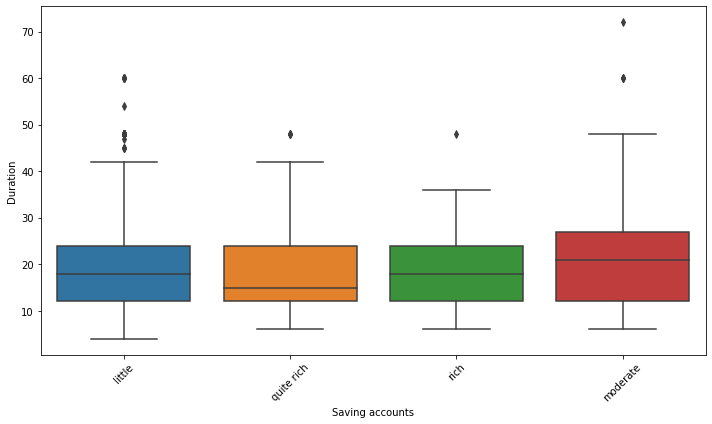

In [10]:
n_credits = data.groupby("Saving accounts")["Credit amount"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)
bar=sns.barplot(data=n_credits,x='Saving accounts',y='Count')
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()
boxes("Saving accounts","Credit amount")
boxes("Saving accounts","Duration")

There are some outliers present but in general,there is not much effect of amount in Savings account on Credit amount or Duration by Housing status.Most customers in dataset have 'little' in Savings account.

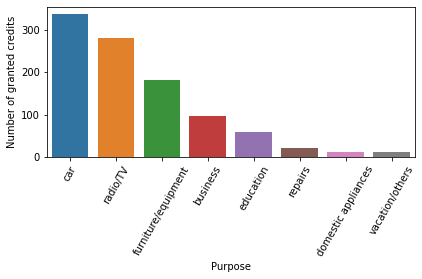

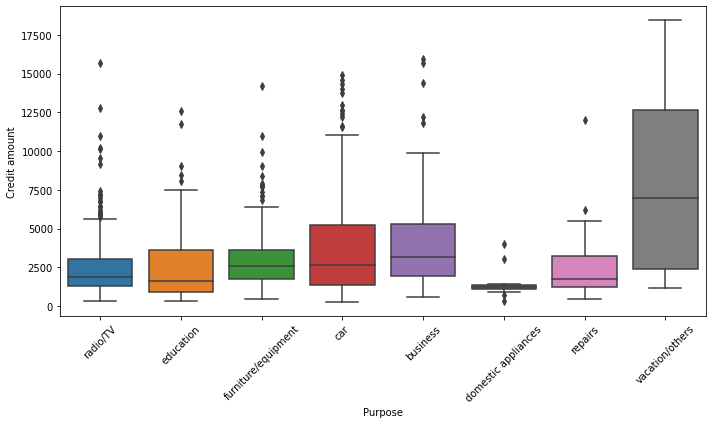

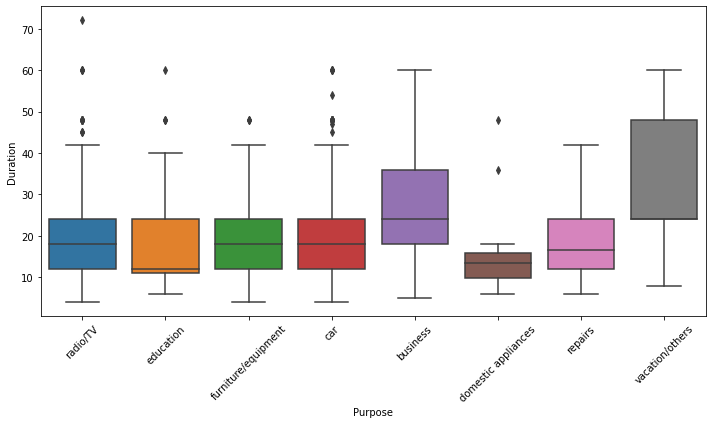

In [11]:
n_credits = data.groupby("Purpose")["Credit amount"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)
bar=sns.barplot(data=n_credits,x='Purpose',y='Count')
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()
boxes("Purpose","Credit amount")
boxes("Purpose","Duration")

Loan taken for vacations are the biggest in terms of credit and of the longest duration.Although the number of loans granted for vacations are very less.Smallest and shortest loans are taken for domestic appliances.Most loans are taken for the first five categories.Using that information,we can say Purpose is not much affecting credit amount or duration.

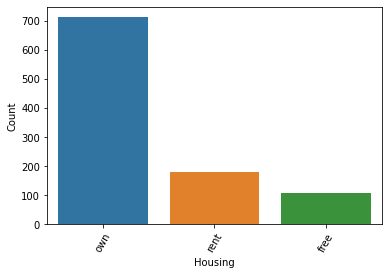

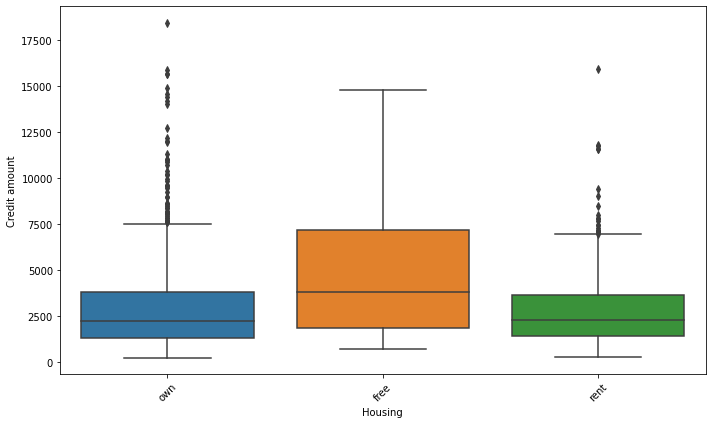

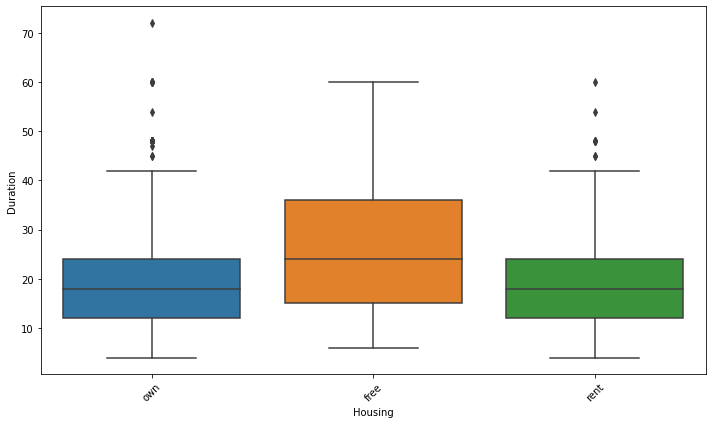

In [12]:
n_credits = data.groupby("Housing")["Credit amount"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)
bar=sns.barplot(data=n_credits,x='Housing',y='Count')
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
boxes("Housing","Credit amount")
boxes("Housing","Duration")

There are some outliers present but in general,there is not much effect of kind own or rented Housing on Credit amount or Duration by Housing status.Most values in the dataset belong to own housing.

### Feature Selection

In [13]:
#K-Means works with Numeric Data
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

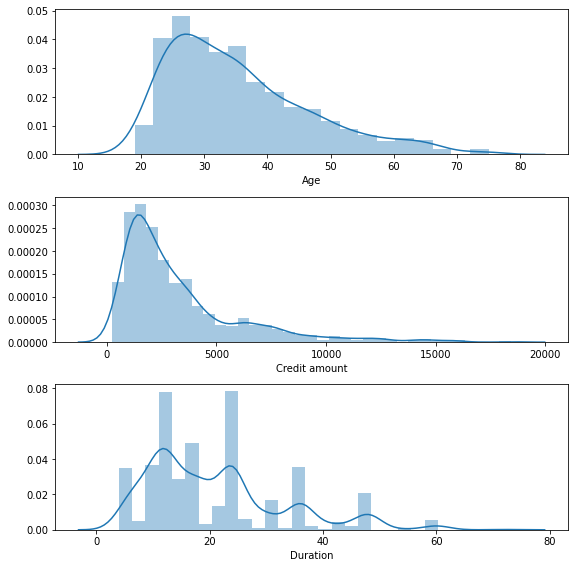

In [14]:
#We see distributions are skewed
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()
distributions(cluster_data)

### Scaling Data

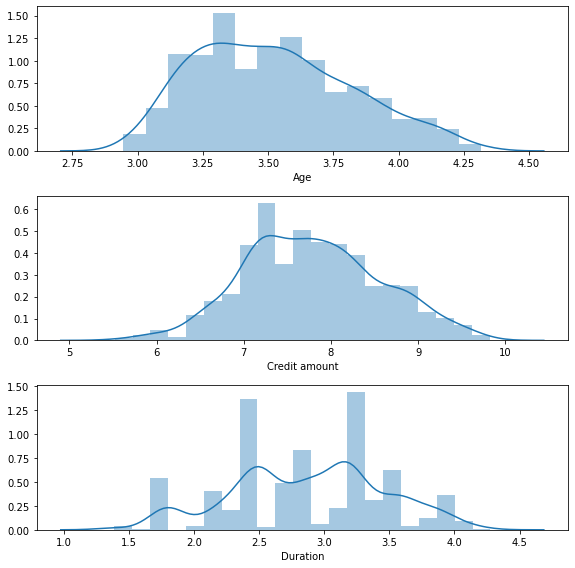

In [15]:
#Log Clustering is performed in response to skewness
cluster_log = np.log(cluster_data)
distributions(cluster_log)

Standardizing data is recommended because otherwise the range of values in each feature will act as a weight when determining how to cluster data, which is typically undesired.Normalization is used to eliminate redundant data and ensures that good quality clusters are generated which can improve the efficiency of clustering algorithms.So it becomes an essential step before clustering as Euclidean distance is very sensitive to the changes in the differences.

In [16]:
#Standardizing Data
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

# Normalizing Data 
normalized_df = normalize(cluster_scaled) 
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df)


### How the K-means algorithm works
To process the learning data, the K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids
It halts creating and optimizing clusters when either:
The centroids have stabilized — there is no change in their values because the clustering has been successful.
The defined number of iterations has been achieved.

#### Setting up K-Means
Now that we have our clusters fixed, let's set up our K-Means Clustering.
The KMeans class has many parameters that can be used, but we will be using these four:

init: Initialization method of the centroids.  
Value will be: "k-means++"  
k-means++: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.  
n_clusters: The number of clusters to form as well as the number of centroids to generate.  
Value will be: Range (2,14)  
n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.  
Value will be: 100  
random_state :Determines random number generation for centroid initialization. Use an int to make the randomness deterministic and results reproducible.
Value will be: 0

### Finding optimum number of clusters

#### Using Scree Plot

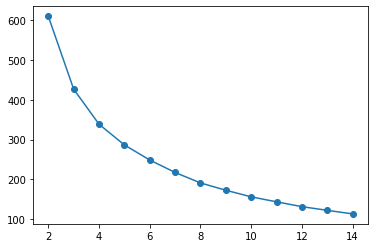

In [17]:
#Plotting Scree Plot to find optimum number of clusters
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(init='k-means++',n_clusters=c,n_init=100, random_state=0).fit(normalized_df)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')
plt.show()

As the number of clusters increases, the variance (within-cluster sum of squares) decreases. The elbow at theree or four clusters represents the most parsimonious balance between minimizing the number of clusters and minimizing the variance within each cluster. 

#### Silhouette Score

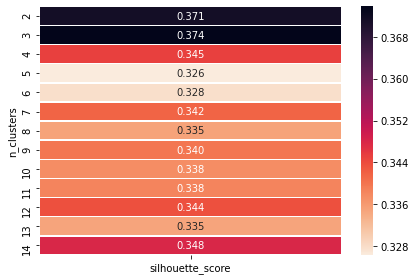

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
results =[]
for c in clusters_range:
    clusterer = KMeans(init='k-means++',n_clusters=c,n_init=100, random_state=0)
    cluster_labels = clusterer.fit_predict(normalized_df)
    silhouette_avg = silhouette_score(normalized_df, cluster_labels)
    results.append([c,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

plt.figure()
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.We get optimum number of clusters as 3.

We would use No of clusters as 3 determined by using Scree plot and Elbow method 

## Fitting KMeans algo for 3 clusters

In [18]:
kmeans_sel = KMeans(init='k-means++',n_clusters=3,n_init=100, random_state=1).fit(normalized_df)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

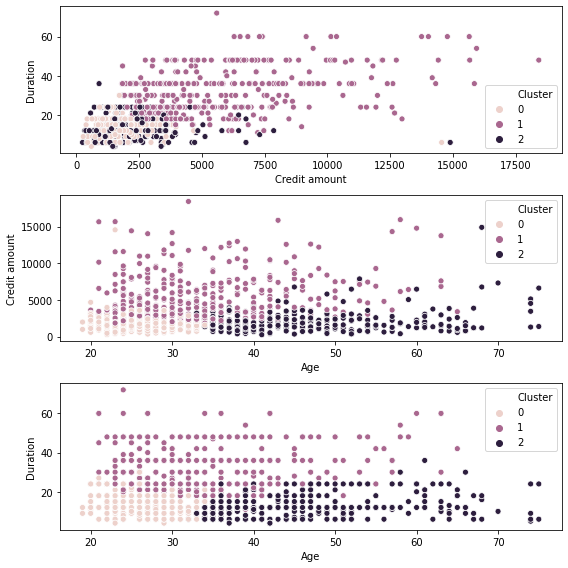

In [20]:
scatters(clustered_data, h='Cluster')

In [19]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

The clusters are well defined for the 2nd and 3rd plot but not so much for the first one.

## Heatmap for Interpretation

In [21]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,26.4,1684.6,14.1
1,33.9,5544.1,31.8
2,46.4,1959.0,13.8


#### Interpretation:

Cluster 0 – Young customers taking low credit loans for short duration  
Cluster 1 – Middle aged customers taking high credit loans for long duration  
Cluster 2 - Old aged customers taking medium credit loans for short duration

## Hierarchial Clustering

### Plotting a Dendrogram

In [22]:
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage

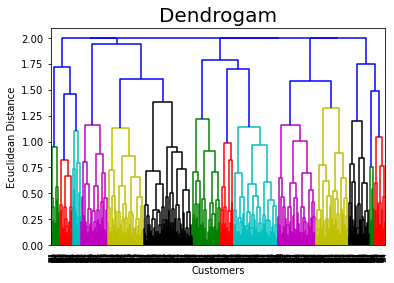

In [23]:
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(normalized_df, method = 'complete'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()


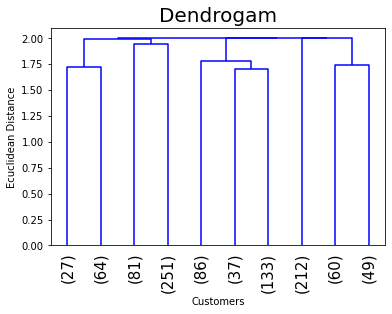

In [24]:
import scipy.cluster.hierarchy as sch 
dendrogram = sch.dendrogram(sch.linkage(normalized_df, method = 'complete'),truncate_mode='lastp',p=10,leaf_rotation=90, leaf_font_size=15) 
plt.title('Dendrogam', fontsize = 20) 
plt.xlabel('Customers') 
plt.ylabel('Ecuclidean Distance') 
plt.show()

## Agglomerative Hierarchical Clustering

In [25]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [26]:
hclust = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')

In [27]:
hclust.fit(normalized_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=3,
                        pooling_func='deprecated')

In [28]:
hclust.fit_predict(normalized_df)

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 0, 2, 1, 2, 1, 1,
       1, 0, 0, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1,
       2, 2, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 1, 0, 2, 0, 1,
       2, 2, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0,
       0, 2, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1,
       2, 0, 1, 0, 1, 0, 1, 0, 2, 1, 1, 2, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 2, 0, 0, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 2, 1,
       0, 0, 2, 0, 1, 1, 0, 1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
       1, 1, 0, 2, 1, 2, 0, 1, 0, 2, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0,
       2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 2, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 0,
       2, 0, 1, 0, 1, 0, 2, 0, 1, 1, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0,

In [29]:
data['Groups'] = hclust.labels_

In [30]:
data.head()
data.Groups.value_counts()

1    423
0    321
2    256
Name: Groups, dtype: int64

In [75]:
data[data.Groups==0].sample(5)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Groups
289,289,48,male,2,own,little,little,1024,24,radio/TV,0
263,263,57,female,1,free,little,NaN,2748,12,education,0
891,891,46,male,2,own,little,NaN,1829,15,radio/TV,0
84,84,52,male,1,own,little,little,2315,10,radio/TV,0
972,972,29,female,0,rent,little,little,1193,24,car,0


Old aged customers taking medium credit loans for 

In [70]:
data[data.Groups==1].sample(5)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Groups
766,766,31,male,1,own,little,little,3108,30,furniture/equipment,1
665,665,27,male,3,own,little,NaN,6314,24,vacation/others,1
888,888,34,male,3,own,little,NaN,6614,36,car,1
583,583,33,male,1,rent,little,moderate,2384,36,repairs,1
728,728,59,female,2,rent,little,moderate,6416,48,business,1


Middle aged customers taking high credit loans for long duration 

In [72]:
data[data.Groups==2].sample(5)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Groups
696,696,29,male,2,own,little,moderate,1103,12,radio/TV,2
795,795,22,female,2,rent,moderate,NaN,2301,9,furniture/equipment,2
700,700,29,female,1,rent,quite rich,NaN,1123,12,furniture/equipment,2
864,864,25,male,1,rent,little,NaN,2210,10,furniture/equipment,2
207,207,26,male,2,own,little,moderate,1424,12,domestic appliances,2


Young customers taking low credit loans for short duration

Looking at the clusters resulted from running both the algorithms we can seggregate customers into 3 groups 
Young customers taking low credit loans for short duration,Middle aged customers taking high credit loans for long duration, 
Old aged customers taking medium credit loans for short duration.

So,now we can accordingly make different marketing strategies and policies 